# Predict Future Sales



과거 판매량 데이터를 기반으로 향후 매장의 총매출과 판매량을 예측하는 프로젝트이다.
 
### Data Description from Kaggle
1. 일일 기록 판매 데이터를 제공
2. 과제는 테스트 세트의 모든 매장에서 판매되는 제품의 총량을 예측하는 것이다. 
3. 상점 및 제품의 목록은 매월 약간씩 변경된다는 점에 유의하십시오.

### Data Description
- train- 2013년 1월부터 2015년 10월까지의 자료
- test - 2015년 11월 이 상점들과 제품들의 판매량을 예측
- shops - 상점에 대한 추가 정보.

## Loading Libraries and Data

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler

from math import ceil

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

%matplotlib inline

train = pd.read_csv('./sales_train.csv')
test = pd.read_csv('./test.csv')
submission = pd.read_csv('./sample_submission.csv')
items = pd.read_csv('./items.csv')
item_cats = pd.read_csv('./item_categories.csv')
shops = pd.read_csv('./shops.csv')

In [99]:
df_train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [100]:
df_train.tail(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


In [101]:
df_test.head(3)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [102]:
df_items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [103]:
df_shops.head(3)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


In [104]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935843 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 156.8+ MB


*우선 테스트 세트에 있는 모든 가게와 아이템이 트레이닝 세트에 있는지 확인*

In [105]:
# test의 shop_id의 중복되지 않은 유일한 값
test_shops = test.shop_id.unique()
# isin
# train의 shop_id에서 test_shops를 포함하는 거만 골라낸다.
train = train[train.shop_id.isin(test_shops)]
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]

In [106]:
# data_block_num 월의 번호
# 2013년 1월은 0, 2013년 2월은 1,,,,2015년 10월,,
MAX_BLOCK_NUM = train.date_block_num.max()
MAX_ITEM = len(test_items)
#item의 category의 개수
MAX_CAT = len(item_cats)
# 2013 ~ 2015
MAX_YEAR = 3
MAX_MONTH = 4 # 7 8 9 10
MAX_SHOP = len(test_shops)

print(MAX_BLOCK_NUM)

33


## Data Exploration

Next, we would like to gain some insights about the data. I will attack from two angles, shop and item categories.

`쇼핑`과 `아이템 카테고리` 집중적

In [107]:
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
grouped.describe()

,shop_id,date_block_num,item_cnt_day
count,1327.000000,1327.000000,1327.000000
mean,30.984175,17.028636,1219.119066
std,17.902886,9.722271,1016.496046
min,2.000000,0.000000,1.000000
25%,15.000000,9.000000,653.000000
50%,31.000000,17.000000,952.000000
75%,47.000000,25.000000,1340.500000
max,59.000000,33.000000,10495.000000


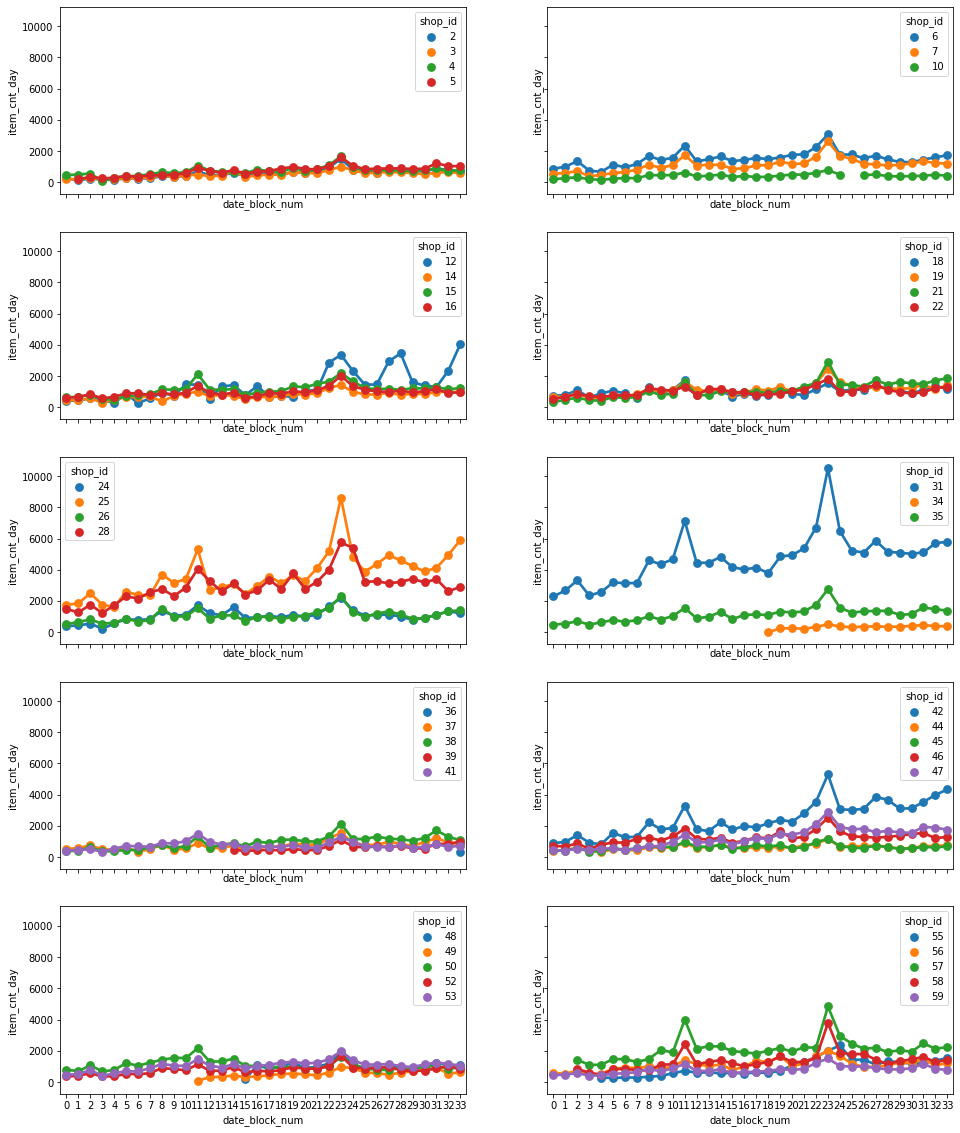

In [108]:

grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
# matplotlib.pyplot.subplots(nrows=1, ncols=1, sharex=False, sharey=False)
#nrows : 몇행을 만들건지
#nrows ; 몇열을 만들것인지
#sharex : Xtick의 값을 각각 공유할지 안할지
#sharey : Ytick의 값을 각각 공유할지 안할지
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
# 그래프 개수
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0
# 행과 열에 대한 for문
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1
# 매달마다 팔린 물건의 개수 나타냄

<정보>

1. 분명히 연말에는 휴가철 때문인지 가게의 판매량 ↑ 
2. 이러한 패턴을 포착하도록 월과 연도를 추가
3. 각 품목별 판매가 어떻게 진행되고 있는지 보기


In [109]:
# add categories
# set_index = 기존의 행 인덱스를 제거, 데이터 열 중 하나를 인덱스로 설정
train = train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()
train.describe()

,item_id,date_block_num,shop_id,item_price,item_cnt_day,item_category_id
count,1.224439e+06,1.224439e+06,1.224439e+06,1.224439e+06,1.224439e+06,1.224439e+06
mean,9.614866e+03,1.935472e+01,3.215117e+01,1.030666e+03,1.321234e+00,4.055878e+01
std,6.299870e+03,9.110722e+00,1.646562e+01,1.827384e+03,3.312997e+00,1.860682e+01
min,3.000000e+01,0.000000e+00,2.000000e+00,5.000000e-01,-1.600000e+01,2.000000e+00
25%,4.181000e+03,1.200000e+01,1.900000e+01,2.990000e+02,1.000000e+00,2.500000e+01
50%,7.856000e+03,2.100000e+01,3.100000e+01,5.490000e+02,1.000000e+00,3.800000e+01
75%,1.522900e+04,2.700000e+01,4.600000e+01,1.199000e+03,1.000000e+00,5.500000e+01
max,2.216700e+04,3.300000e+01,5.900000e+01,5.920000e+04,2.169000e+03,8.300000e+01


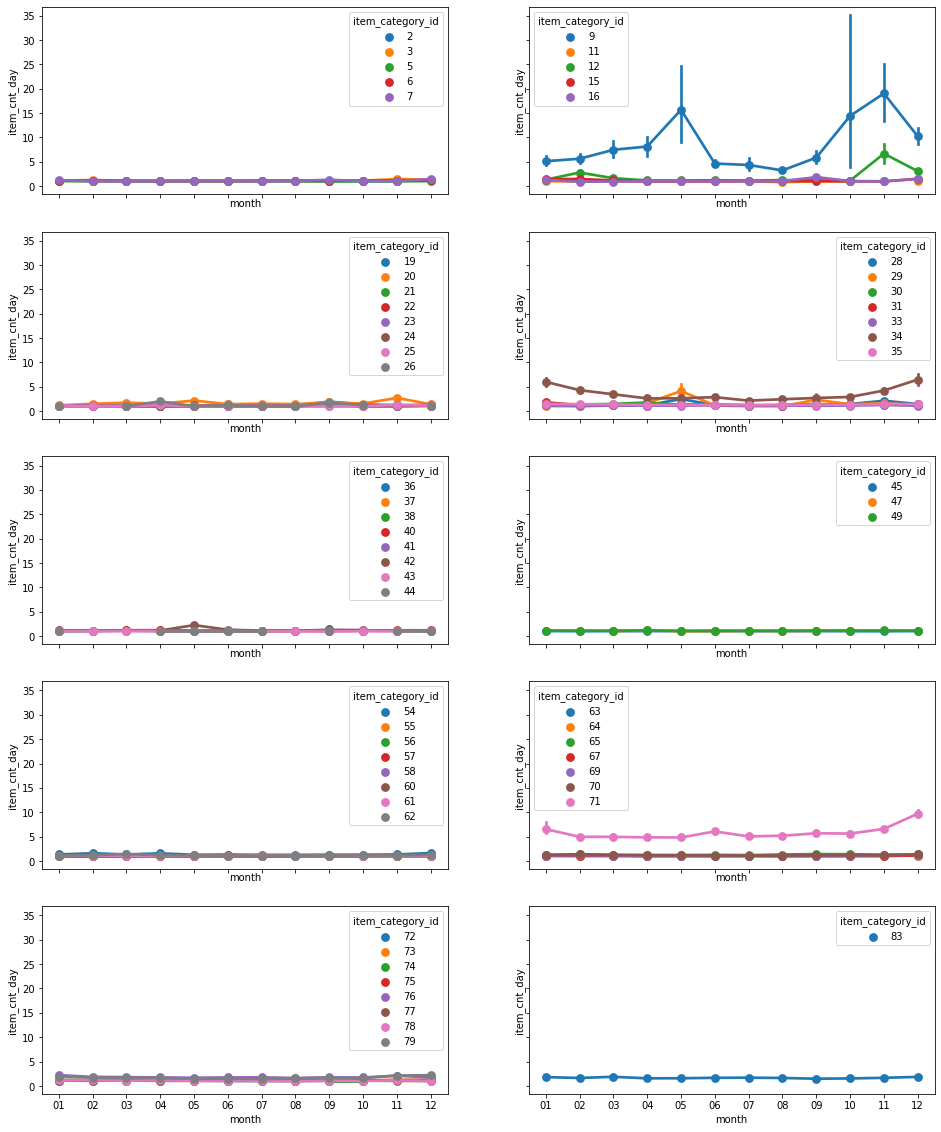

In [110]:
# 월과 년도를 뽑는 작업
# strftime() : 문자열 반환
train['month'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%m'))
train['year'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y'))

# matplotlib.pyplot.subplots(nrows=1, ncols=1, sharex=False, sharey=False)
#nrows : 몇행을 만들건지
#nrows ; 몇열을 만들것인지
#sharex : Xtick의 값을 각각 공유할지 안할지
#sharey : Ytick의 값을 각각 공유할지 안할지
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
# ceil 올림 모듈
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1
        
# 어떤 아이템이 가장 잘팔렸는지??

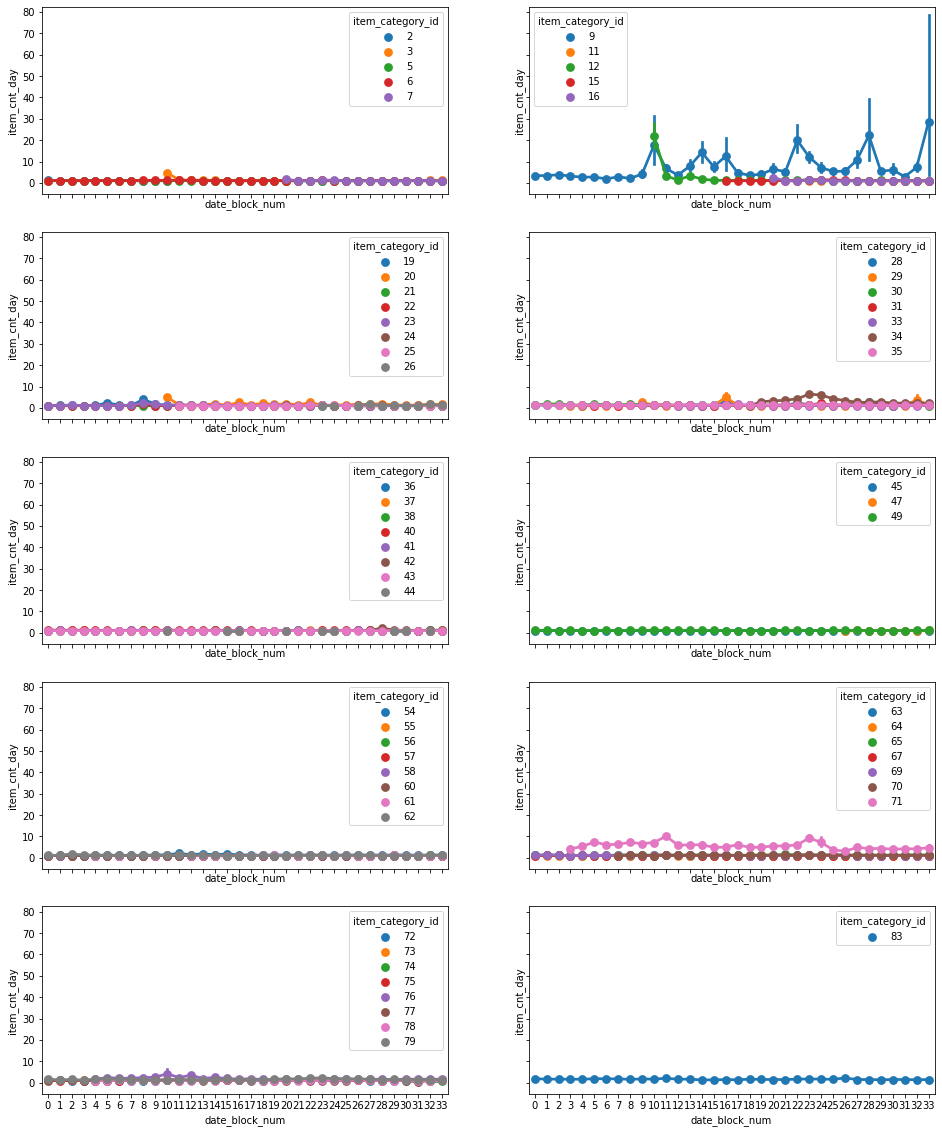

In [111]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

In [112]:
# 'date' , 'item_category_id'칼럼 전체를 삭제
train = train.drop('date', axis=1)
train = train.drop('item_category_id', axis=1)
train = train.groupby(['shop_id', 'item_id', 'date_block_num', 'month', 'year']).sum()
train.describe()
train = train.sort_index()


## Training